## Setup

Import TensorFlow and other necessary libraries:

In [1]:
import tensorflow as tf

from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

## Load data using a Keras utility

Next, load these images off disk using the helpful tf.keras.utils.image_dataset_from_directory utility.
This will take you from a directory of images on disk to a tf.data.Dataset in just a couple lines of code.

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = (180, 180)

In [3]:
data_dir = "../data/raw"

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)



Found 59849 files belonging to 50 classes.
Using 47880 files for training.
Found 59849 files belonging to 50 classes.
Using 11969 files for validation.


In [4]:
class_names = train_ds.class_names
print(class_names)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Black_grass___healthy', 'Blueberry___healthy', 'Charlock___healthy', 'Cherry___Powdery_mildew', 'Cherry___healthy', 'Cleavers___healthy', 'Common_Chickweed___healthy', 'Common_wheat___healthy', 'Corn___Common_rust', 'Corn___Gray_leaf_spot', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Fat_Hen___healthy', 'Grape___Black_Measles', 'Grape___Black_rot', 'Grape___Isariopsis_Leaf_Spot', 'Grape___healthy', 'Loose_Silky_bent___healthy', 'Maize___healthy', 'Orange___Citrus_greening', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper_bell___Bacterial_spot', 'Pepper_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Scentless_Mayweed___healthy', 'Shepherds_Purse___healthy', 'Small_flowered_Cranesbill___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Sugar_beet___healthy', 'Tomat

As the original dataset doesn't contain a test set, you will create one.
To do so, determine how many batches of data are available in the validation set using `tf.data.experimental.cardinality`, then move 20% of them to a test set.

In [5]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 300
Number of test batches: 75


## Configure the dataset for performance

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking.

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Transfer Learning approach

Create the base model from the pre-trained model MobileNetV2

In [7]:
# This model expects pixel values in [-1, 1], but at this point, the pixel values in your images are in [0, 255]
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

IMG_SHAPE = IMAGE_SIZE + (3,)
# base_model = MobileNetV2(input_shape=IMG_SHAPE,
base_model = MobileNetV2(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
                         include_top=False,
                         weights='imagenet')

image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

# Freeze the base model
base_model.trainable = False

C:\Users\lume\AppData\Local\Temp\ipykernel_4700\3662819757.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),


(32, 6, 6, 1280)


In [8]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 90, 90,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 90, 90,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 90, 90,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 90, 90,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 90, 90,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 90, 90,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 90, 90,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 90, 90,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 90, 90,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 90, 90,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 90, 90,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 91, 91,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 45, 45,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 45, 45,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 45, 45,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 45, 45,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
# Add a classification head
global_average_layer = layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
prediction_layer = layers.Dense(1, activation='sigmoid')
# prediction_layer = layers.Dense(len(train_ds.class_names), activation='softmax')

In [10]:
# Build the model
inputs = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
layer = preprocess_input(inputs)
layer = base_model(layer, training=False)
layer = global_average_layer(layer)
layer = tf.keras.layers.Dropout(0.2)(layer)
outputs = prediction_layer(layer)

model = tf.keras.Model(inputs, outputs)

# model = models.Sequential([
#     base_model,
#     global_average_layer,
#     prediction_layer
# ])

## Compile the model

Compile the model before training it. Since there are two classes and a sigmoid oputput, use the `BinaryAccuracy`.

In [11]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

# model.compile(optimizer=tf.keras.optimizers.Adam(),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#               metrics=['accuracy'])

## Train the model

After training for 10 epochs, you should see ~96% accuracy on the validation set.

In [12]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

300/300 ━━━━━━━━━━━━━━━━━━━━ 126s 367ms/step - accuracy: 0.0065 - loss: -13.5044


In [13]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

initial loss: -13.57
initial accuracy: 0.01
Epoch 1/10
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 843s 437ms/step - accuracy: 0.0104 - loss: -591.1650 - val_accuracy: 0.0094 - val_loss: -2305.9897
Epoch 2/10
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 631s 422ms/step - accuracy: 0.0107 - loss: -2889.1614 - val_accuracy: 0.0094 - val_loss: -4601.4453
Epoch 3/10
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 631s 421ms/step - accuracy: 0.0102 - loss: -5203.4971 - val_accuracy: 0.0094 - val_loss: -6894.8911
Epoch 4/10
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 631s 422ms/step - accuracy: 0.0102 - loss: -7476.0601 - val_accuracy: 0.0094 - val_loss: -9191.2910
Epoch 5/10
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 624s 417ms/step - accuracy: 0.0114 - loss: -9779.8447 - val_accuracy: 0.0094 - val_loss: -11486.4990
Epoch 6/10
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 624s 417ms/step - accuracy: 0.0105 - loss: -12177.3545 - val_accuracy: 0.0094 - val_loss: -13777.3936
Epoch 7/10
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 628s 419ms/step - accuracy: 0.0108 - loss: -14469.0146 - val

## Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

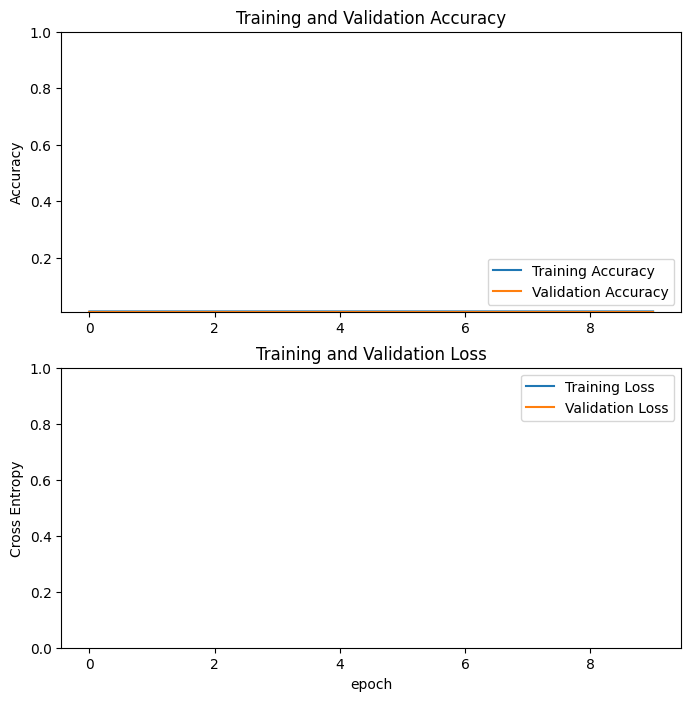

In [15]:
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning

In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were not updated during training.

In [16]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


## Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [17]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

## Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [18]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=val_ds)

Epoch 11/20
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 1010s 666ms/step - accuracy: 0.0107 - loss: -38377.4648 - val_accuracy: 0.0094 - val_loss: -91592.0625
Epoch 12/20
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 982s 656ms/step - accuracy: 0.0103 - loss: -65917.0000 - val_accuracy: 0.0094 - val_loss: -83406.5625
Epoch 13/20
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 981s 655ms/step - accuracy: 0.0102 - loss: -68973.7578 - val_accuracy: 0.0094 - val_loss: -80261.4766
Epoch 14/20
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 986s 659ms/step - accuracy: 0.0096 - loss: -70991.2578 - val_accuracy: 0.0094 - val_loss: -79558.8125
Epoch 15/20
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 981s 655ms/step - accuracy: 0.0106 - loss: -72570.7891 - val_accuracy: 0.0094 - val_loss: -79937.5000
Epoch 16/20
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 980s 655ms/step - accuracy: 0.0096 - loss: -74522.6719 - val_accuracy: 0.0094 - val_loss: -79976.1641
Epoch 17/20
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 986s 659ms/step - accuracy: 0.0102 - loss: -76171.3359 - val_accuracy: 0.0094 - val_lo

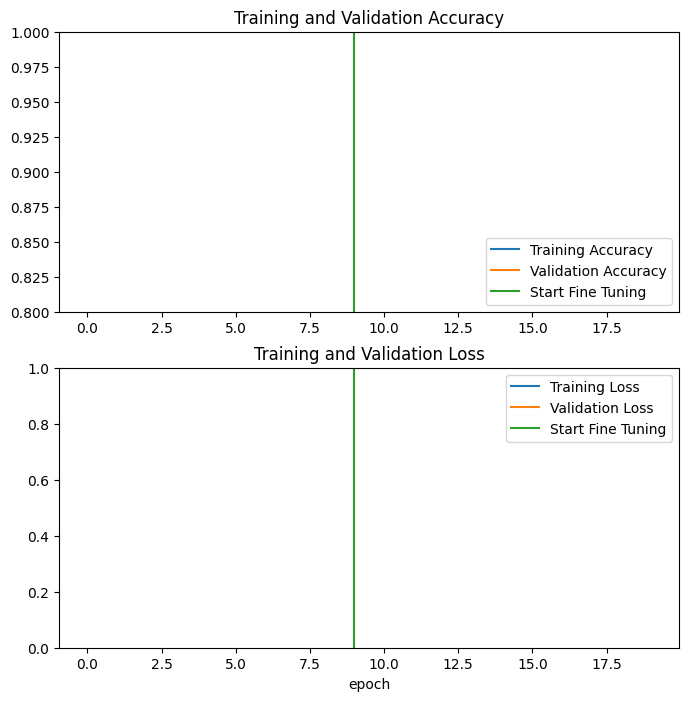

In [19]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Evaluation and prediction

Finally you can verify the performance of the model on new data using test set.

In [20]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

75/75 ━━━━━━━━━━━━━━━━━━━━ 43s 500ms/step - accuracy: 0.0180 - loss: -84922.9062
Test accuracy : 0.013749999925494194


Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [43 40 12 36 10 26 47 35 40 16 47 35 15 17 21 41 24 36 29 15 40 21 12 17
  3 35 47 40 49  5 46 15]


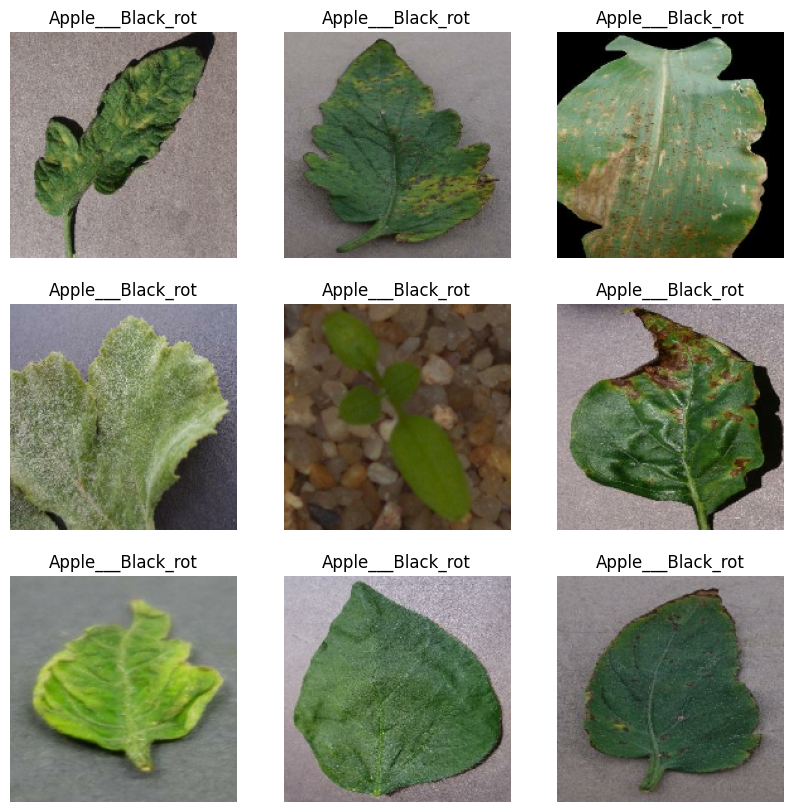

In [21]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")